In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import datetime

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from scipy.stats import *
from catboost import *
from catboost.utils import *

le = LabelEncoder()
scaler = MinMaxScaler()

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

# Introduzione

Il lavoro svolto di seguito parte da un dataset di cui non si conosce il significato delle features e il corretto formato. Tuttavia pare evidente essere di fronte ad un dataset strutturato con sia dati numerici che categorici, dato anche il soggetto da cui arriva il dataset (una società assicurativa) e lo scopo 
dell'analisi. 

Per questo motivo ho ritenuto importante investigare quali delle features presenti possono essere effettivamente numeriche o 
categoriche, in modo da scegliere il corretto algoritmo e applicare le tecniche di riempimento dei valori nulli e le riscalutare più consone.

# 1.0 Data retrival

Carico i due dataset e li metto insieme (togliendo la variabile di risposta) per fare subito il preprocessing sulle X del train e del test set. Il modello poi sarà trainato solo sulle x del train, e la predict sarà effettuata sulle X del test, già processate.

In [2]:
df = pd.read_csv('train_set.zip', compression='zip',low_memory=False)
test = pd.read_csv('test_set.zip', compression='zip',low_memory=False)

y = df[['target']]
df = df.drop(columns='target')

df = df.append(test)
df = df.drop(columns='index')

# 2.0 Preprocessing

## 2.1 Colonne con NaN

Elimino dal dataset le colonne che presentano valori nulli per oltre il 50% dei dati presenti.

In [3]:
df = df.loc[:, df.isnull().mean() < .5]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Columns: 294 entries, feature_0 to feature_294
dtypes: float64(212), int64(75), object(7)
memory usage: 45.0+ MB


## 2.2 Colonne con lettere/stringhe

Su queste features utilizzo il label encoder (anche se non sono labels) per tradurre il valore da lettera a "numero", dopo aver riempito i valori nulli con il valore più frequente.

In [5]:
ob = df.select_dtypes(include='object')

for i in ob.columns:
    ob[i] = ob[i].fillna(ob[i].mode()[0])

ob = ob.astype('str')

for i in ob.columns:
    le.fit(ob[i])
    ob[i] = le.transform(ob[i])

for i in ob.columns:
    df[i] = ob[i]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Columns: 294 entries, feature_0 to feature_294
dtypes: float64(212), int32(7), int64(75)
memory usage: 44.5 MB


## 2.2 Colonne fittiziamente numeriche

Ci sono alcune colonne che presentano valori numerici ma in realtà sembrano delle codifiche di variabili categoriche o simili. Ho notato che le effettive numeriche sono del tipo: 0.34534443.
Quelle dubbie invece sono: 0,0.5,1,2,3,ecc... Così facendo vado a vedere per ogni colonna i suoi valori univoci e mi trovo il valore con più cifre. Se il valore con più cifre è inferiore ad
una data soglia (3 in questo caso) lo faccio diventare una categorica.

In [6]:
num = df.select_dtypes(include='float64')
num = num.astype('str')

for i in num.columns:
    if len(max(list(num[i]),key=len))<=3:
        num[i] = num[i].astype('object')
    else:
        num[i] = num[i].astype('float')

for i in num.columns:
    df[i] = num[i]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Columns: 294 entries, feature_0 to feature_294
dtypes: float64(202), int32(7), int64(75), object(10)
memory usage: 44.5+ MB


## 2.3 Finti interi

Le features con type "int" presentano valori interi "sospetti": 0,1,ecc... Queste le considero categoriche, ad esclusione di alcune che presentano una possibile "ordinalità" che tengo numeriche.

In [7]:
n = ['feature_1','feature_8','feature_12','feature_16','feature_17']

In [8]:
for i in df.columns:
    if ((df[i].dtype == 'int32') | (df[i].dtype == 'int64')) and i not in n:
        df[i] = df[i].astype('object')
    elif i in n:
        df[i] = df[i].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Columns: 294 entries, feature_0 to feature_294
dtypes: float64(207), object(87)
memory usage: 45.0+ MB


## 2.4 Check sulle numeriche

Ultimo check sulle numeriche rimaste: quelle che presentano pochi valori univoci le faccio diventare categoriche.

In [9]:
for i in df.columns:
    if (df[i].nunique() < 3):
        df[i] = df[i].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Columns: 294 entries, feature_0 to feature_294
dtypes: float64(206), object(88)
memory usage: 45.0+ MB


## 2.5 Categoriche

Per le variabili categoriche ho deciso di escludere quelle che presentano un solo valore (non aggiunge informazione all'algortimo) e quelle che presentano più di 20 valori (una di queste pare essere il CAP o qualcosa del genere).

Una volta effettuate queste operazioni, ricontrollando le "rimanenti" categoriche mi accorgo che alcune possono essere considerate numeriche (dato più utile al 
classificatore) e quindi le trasformo in numeriche.

In [10]:
cat = df.select_dtypes(include='object')

In [11]:
cat = cat.loc[:, cat.nunique()>1]
cat = cat.loc[:, cat.nunique()<20]
cat.shape

(20000, 31)

In [12]:
for i in cat:
    if cat[i].nunique()>3:
        cat[i] = cat[i].astype('float64')
cat = cat.select_dtypes(include='object')
cat.shape

(20000, 20)

## 2.6 Numeriche

Creo il dataset delle sole numeriche rimaste dopo la pulizia dei NaN eccessivi e delle categoriche. Per riempire i valori nulli delle numeriche ho deciso di avvalermi di statistiche descrittive base: ho guardato il valore dell'assimetria per ogni colonna e se questa presentava un valore oltre una data soglia (3,-3) ho riempito con la moda (data la forte asimmetria dei dati nella colonna), viceversa con la mediana per le variabili più gaussiane.

In [13]:
df_mice = pd.concat([df.select_dtypes(include='float64'),cat.select_dtypes(include='float64')],axis=1)

In [14]:
for i in df_mice.columns:
    if (df_mice[i].skew()>=3) | (df_mice[i].skew()<=-3):
        df_mice[i] = df_mice[i].fillna(df_mice[i].mode()[0])
    else:
        df_mice[i] = df_mice[i].fillna(df_mice[i].median())

## 2.7 Riscalatura

Uniformo le variabili numeriche tra 0 e 1 con una riscalatura semplice.

In [15]:
scaler.fit(df_mice)
df_mice_scaled = scaler.transform(df_mice)
df_mice_scaled = pd.DataFrame(df_mice_scaled,columns=df_mice.columns)
df_mice_scaled.shape

(20000, 206)

Elimino le colonne che presentano un livello di correlazione superiore al 75%

In [16]:
corr_matrix = df_mice_scaled.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df_mice_scaled = df_mice_scaled.drop(df_mice_scaled[to_drop], axis=1)
df_mice_scaled.shape

(20000, 102)

## 2.8 Unione dataset

Creo il dataset finale da utilizzare per il classificatore.

In [17]:
df_mice_scaled = df_mice_scaled.reset_index()
cat = cat.reset_index()
dff = pd.concat([df_mice_scaled,cat],axis=1)
dff.shape

(20000, 124)

# 3.0 Modelling

Dato che il dataset finale è composto sia da variabili numeriche che da variabili categoriche ho deciso di avvalermi di un modello che non 
fosse una "black-box" (come il caso di una rete neurale) ma di un modello più "comprensibile", in grado di trattare i dati presenti. Immaginando il possibile obiettivo di business dell'analisi, sapere quali "features" sono più determinanti nell'individuare un possibile cliente pronto all'abbandono può essere decisamente 
utile. Utilizzando una black-box quest'informzione non è sempre disponibile.

La scelta dell'algoritmo
è ricaduta su "CatBoost" un modello di classificazione basato sul boosting di alberi di decisione in grado di lavorare sia sui dati numerici
che sui dati categorici (applicando tecniche potenzialmente più informative del classico "one-hot-encoding").

In [18]:
train_i = dff.head(10000)
test_f = dff.tail(10000)
train_i = train_i.drop(columns=['index'])
test_f = test_f.drop(columns=['index'])
train_i = pd.concat([train_i,y],axis=1)

## 3.1 Classi sbilanciate?

La classe oggetto di predizione presenta uno sbilanciamento. Questo aspetto se non trattato non permette all'algortimo di generalizzare a 
sufficienza, finendo quindi con l'imparare a riconoscere solo la classe maggioritaria. Come trattare questo aspetto?

La scelta è ricadauta sull'effettuare l'undersample della classe maggiormente presente, portandola circa al livello della classe meno presente.
Ho scelto questa soluzione perché ho ritenuto l'oversample una fonte di overfitting evitabile (anche con l'introduzione di dati "sinteci" 
tramie lo SMOTE).

In [19]:
X = train_i.drop(columns=['target'])
y = train_i[['target']].astype(int)

rus = RandomUnderSampler(sampling_strategy=0.9)
X_resampled, y_resampled = rus.fit_resample(X,y)

df_all = pd.concat([X_resampled,y_resampled],axis=1)
df_all = df_all.sample(frac=1)

df_all.target.value_counts()

0    1364
1    1228
Name: target, dtype: int64

## 3.2 Model

Divido in 3 parti il dataset finale per effetuare l'analisi e la valutazione.

In [20]:
for i in df_all.columns:
    if df_all[i].dtypes =='object':
        df_all[i] = df_all[i].astype('str')

In [21]:
train, validate, test = np.split(df_all.sample(frac=1), [int(.7*len(df_all)), int(.85*len(df_all))])

In [22]:
x_train = train.drop(columns=['target'])
y_train = train[['target']]
x_val = validate.drop(columns=['target'])
y_val = validate[['target']]
x_test = test.drop(columns=['target'])
y_test = test[['target']]

### 3.2.1 Catboost

In [23]:
categorical_features_indices1 = np.where(x_train.dtypes != np.float64)[0]
model = CatBoostClassifier(iterations=300,eval_metric='F1',loss_function='Logloss',random_seed=6)
model.fit(x_train, y_train, cat_features=categorical_features_indices1, verbose=100,eval_set=(x_val,y_val),plot=False)

Learning rate set to 0.061979
0:	learn: 0.5208776	test: 0.4593640	best: 0.4593640 (0)	total: 210ms	remaining: 1m 2s
100:	learn: 0.8274174	test: 0.5828221	best: 0.6073620 (88)	total: 3.11s	remaining: 6.13s
200:	learn: 0.9651506	test: 0.5531915	best: 0.6073620 (88)	total: 5.67s	remaining: 2.79s
299:	learn: 0.9982384	test: 0.5443787	best: 0.6073620 (88)	total: 8.23s	remaining: 0us

bestTest = 0.6073619632
bestIteration = 88

Shrink model to first 89 iterations.


La differenza tra i risultati del train e del validation/test set evidenzia come sia presente dell'overfitting nel modello, non riuscendo a 
generalizzare adeguatamente, ma dato lo scopo del modello e le poche informazioni disponibili ritengo sia un risultato soddisfacente.

Model Train F1: 0.8085889570552148
Model Validation F1: 0.6073619631901841
---------------------------------------------
Model Test F1: 0.6218487394957984
Model Classification Report
              precision    recall  f1-score   support

           0       0.62      0.74      0.68       192
           1       0.69      0.56      0.62       197

    accuracy                           0.65       389
   macro avg       0.66      0.65      0.65       389
weighted avg       0.66      0.65      0.65       389

---------------------------------------------
Model Confusion Matrix


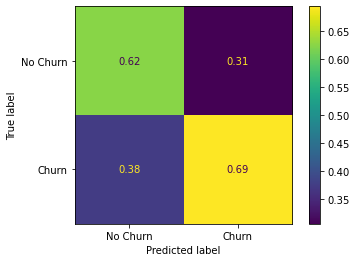

In [24]:
y_val_predict = model.predict(x_val)
print("Model Train F1:", f1_score(y_train, model.predict(x_train)))
print("Model Validation F1:", f1_score(y_val, y_val_predict))
print('---------------------------------------------')
y_test_predict_grid = model.predict(x_test)
print("Model Test F1:", f1_score(y_test, y_test_predict_grid))
print('Model Classification Report')
print(classification_report(y_test, y_test_predict_grid))
print('---------------------------------------------')
print('Model Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix(y_test,y_test_predict_grid,normalize='pred'),display_labels=['No Churn','Churn']).plot()

# 4.0 Predict e file di output

Genero il file csv per la subssion sul sito.

In [25]:
# test_f['pred'] = model.predict(test_f[x_test.columns])
# ris = test_f['pred'].astype(int)
# ris.to_csv('sub.csv',index=False,header=False)

Ulteriori info:
    
Nei test effettuati ho provato:
- varie tipologie di riscalature (beta, logaritmica)
- varie tipologie di tecniche di riempimento dei buchi (MICE, KNN)
- varie tipologie di ribilanciamento delle classi
- varie tipologie di tecniche di selezione delle features per il classificatore (su tutte ho guardato le distribuzioni delle features tra i due gruppi per individuare quali features presentavano maggiori differenze)

con risultati (al momento scadenti). 